In [3]:
import jax.numpy as jnp
import jax
from jax import vmap, jit, grad
import optax
from functools import partial
import numpy as np
from tqdm import trange
from jax import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import sys
sys.path.insert(0, '../')

from KANWrapper import SF_KAN  # Base KAN implementation


In [4]:
def create_domain_points(L_range, H_range, T_range, nx, ny, nt):
    x = np.linspace(L_range[0], L_range[1], nx)
    y = np.linspace(H_range[0], H_range[1], ny)
    t = np.linspace(T_range[0], T_range[1], nt)
    
    # Interior points
    X, Y, T = np.meshgrid(x, y, t, indexing='ij')
    interior_points = np.column_stack((X.ravel(), Y.ravel(), T.ravel()))
    
    # Boundary points (x and y faces, t ≥ 0)
    x_faces = np.vstack([
        np.column_stack((
            np.full(ny * nt, L_range[0]), 
            np.tile(y, nt), 
            np.repeat(t, ny)
        )),
        np.column_stack((
            np.full(ny * nt, L_range[1]), 
            np.tile(y, nt), 
            np.repeat(t, ny)
        ))
    ])
    
    y_faces = np.vstack([
        np.column_stack((
            np.tile(x, nt),
            np.full(nx * nt, H_range[0]), 
            np.repeat(t, nx)
        )),
        np.column_stack((
            np.tile(x, nt),
            np.full(nx * nt, H_range[1]), 
            np.repeat(t, nx)
        ))
    ])
    
    # Initial condition (t = 0) for the interior points
    X_ic, Y_ic = np.meshgrid(x[1:-1], y[1:-1], indexing='ij')  # Exclude boundary points to avoid duplicates
    ic_interior = np.column_stack((X_ic.ravel(), Y_ic.ravel(), np.zeros_like(X_ic.ravel())))
    
    # Combine all boundary and initial condition points
    boundary_points = np.vstack([x_faces, y_faces, ic_interior])
    
    return interior_points, boundary_points
 
# Example usage
L_range = (0.0, 1.0)
H_range = (0.0, 1.0)
T_range = (0.0, 10.0)
nx, ny, nt = 50, 50, 50
interior_points, boundary_points = create_domain_points(L_range, H_range, T_range, nx, ny, nt)

# Create full meshgrid if needed for visualization
x = np.linspace(L_range[0], L_range[1], nx)
y = np.linspace(H_range[0], H_range[1], ny)
t = np.linspace(T_range[0], T_range[1], nt)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')

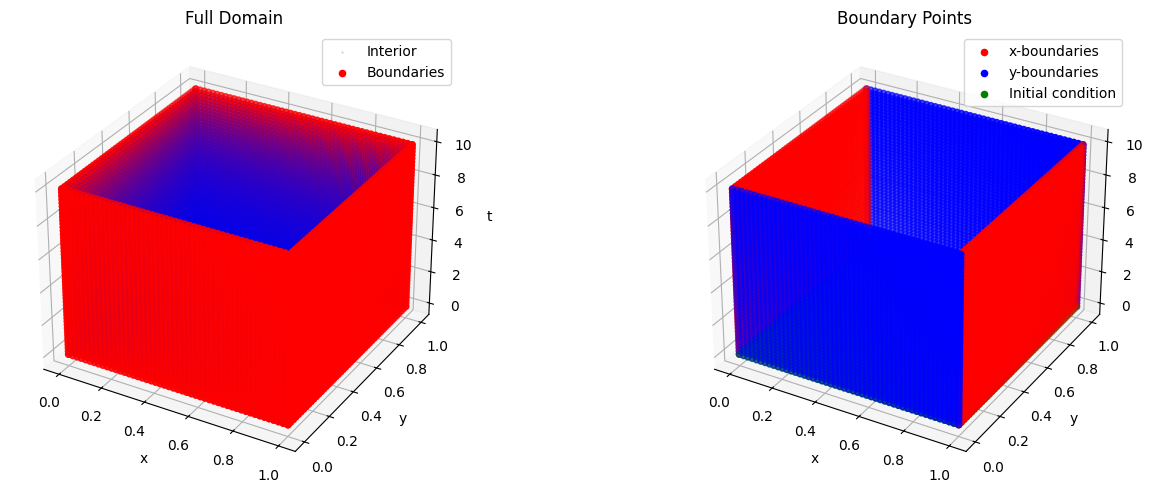

In [5]:
def plot_domain_3d(X, Y, T):
    """
    Plot 3D visualization of the computational domain.
    
    Args:
        X, Y, T: Meshgrid arrays defining the domain
    """
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Full domain with all points
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Interior points
    ax1.scatter(X.ravel(), Y.ravel(), T.ravel(), 
               c='blue', alpha=0.1, s=1, label='Interior')
    
    # All boundary points
    # x-boundaries
    ax1.scatter(X[0,:,:].ravel(), Y[0,:,:].ravel(), T[0,:,:].ravel(), 
               c='red', s=20, label='Boundaries')
    ax1.scatter(X[-1,:,:].ravel(), Y[-1,:,:].ravel(), T[-1,:,:].ravel(), 
               c='red', s=20)
    
    # y-boundaries
    ax1.scatter(X[:,0,:].ravel(), Y[:,0,:].ravel(), T[:,0,:].ravel(), 
               c='red', s=20)
    ax1.scatter(X[:,-1,:].ravel(), Y[:,-1,:].ravel(), T[:,-1,:].ravel(), 
               c='red', s=20)
    
    # Initial condition (t=0)
    ax1.scatter(X[:,:,0].ravel(), Y[:,:,0].ravel(), T[:,:,0].ravel(), 
               c='red', s=20)
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('t')
    ax1.set_title('Full Domain')
    ax1.legend()
    
    # Plot 2: Only boundary points with different colors
    ax2 = fig.add_subplot(122, projection='3d')
    
    # x-boundaries (front and back faces)
    ax2.scatter(X[0,:,:].ravel(), Y[0,:,:].ravel(), T[0,:,:].ravel(), 
               c='red', s=20, label='x-boundaries')
    ax2.scatter(X[-1,:,:].ravel(), Y[-1,:,:].ravel(), T[-1,:].ravel(), 
               c='red', s=20)
    
    # y-boundaries (left and right faces)
    ax2.scatter(X[:,0,:].ravel(), Y[:,0,:].ravel(), T[:,0,:].ravel(), 
               c='blue', s=20, label='y-boundaries')
    ax2.scatter(X[:,-1,:].ravel(), Y[:,-1,:].ravel(), T[:,-1,:].ravel(), 
               c='blue', s=20)
    
    # Initial condition (t=0, bottom face)
    ax2.scatter(X[:,:,0].ravel(), Y[:,:,0].ravel(), T[:,:,0].ravel(), 
               c='green', s=20, label='Initial condition')
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('t')
    ax2.set_title('Boundary Points')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


plot_domain_3d(X, Y, T)

In [6]:

class KleinGordon_KAN(SF_KAN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @partial(jit, static_argnums=(0,))
    def exact_solution(self, x, y, t):
        return (x + y) * jnp.cos(t) + x * y * jnp.sin(t)

    @partial(jit, static_argnums=(0,))
    def forcing_term(self, x, y, t):
        u = self.exact_solution(x, y, t)
        return u**2 - u

    @partial(jit, static_argnums=(0,))
    def loss_fn(self, params, state, xy_domain, xy_boundary):
        variables = {'params': params, 'state': state}
        
        # Get predictions for domain and boundary points
        pred_domain, spl_regs = self.forward_pass(variables, xy_domain)
        pred_boundary, _ = self.forward_pass(variables, xy_boundary)

        # Physics loss (Klein-Gordon equation with forcing term)
        def kg_residual(point):
            x, y, t = point

            def u(p):
                return self.forward_pass(variables, p.reshape(1, -1))[0][0, 0]

            # Compute derivatives
            u_t = grad(lambda t_var: u(jnp.array([x, y, t_var])))(t)
            u_tt = grad(lambda t_var: grad(lambda t_var: u(jnp.array([x, y, t_var])))(t_var))(t)
            u_xx = grad(lambda x_var: grad(lambda x_var: u(jnp.array([x_var, y, t])))(x_var))(x)
            u_yy = grad(lambda y_var: grad(lambda y_var: u(jnp.array([x, y_var, t])))(y_var))(y)
            
            u_val = u(jnp.array([x, y, t]))
            f_val = self.forcing_term(x, y, t)
            
            # Residual of the Klein-Gordon equation
            residual = u_tt - (u_xx + u_yy) + u_val**2 - f_val
            return residual

        # Vectorize residual computation over domain points
        physics_residuals = vmap(kg_residual)(xy_domain)
        physics_loss = jnp.mean(physics_residuals**2)

        # Boundary loss: compare predictions with exact solution at boundary points
        exact_vals = vmap(self.exact_solution)(xy_boundary[:, 0], xy_boundary[:, 1], xy_boundary[:, 2])
        boundary_loss = jnp.mean((pred_boundary[:, 0] - exact_vals)**2)

        # Regularization loss from spline regularization terms
        flattened_spl_reg = [jnp.ravel(arr) for arr in spl_regs]
        reg_loss = jnp.sum(jnp.concatenate(flattened_spl_reg))

        # Total loss includes physics loss, boundary loss, and regularization loss
        total_loss = physics_loss + boundary_loss #+ 0.1* reg_loss
        return total_loss

In [7]:

# Model parameters
layer_dims = [3, 5, 5, 1]
init_lr = 1e-2

# KAN parameters
k = 3 # spline order

model = KleinGordon_KAN(
    layer_dims=layer_dims,
    init_lr=init_lr,
    k = k
)

# Train the model
num_epochs = 1#10000
final_variables, loss_history = model.train(
    num_epochs=num_epochs,
    xy_domain=interior_points,
    xy_boundary=boundary_points
)


100%|██████████| 1/1 [00:35<00:00, 35.91s/it, Loss=2.0531e+01]


In [ ]:
# Plot loss history
def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 6))
    epochs = range(0, len(loss_history), 100)
    plt.plot(epochs, loss_history[::100])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for y-axis
    plt.title('Training Loss History')
    plt.grid(True)
    plt.show()

plot_loss_history(loss_history)

L2 error at t = 1.0: 4.319950e-01
L2 error at t = 3.0: 1.711478e+00
L2 error at t = 5.0: 5.380049e-01
L2 error at t = 10.0: 2.389710e+00


/tmp/ipykernel_1291/4183913797.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


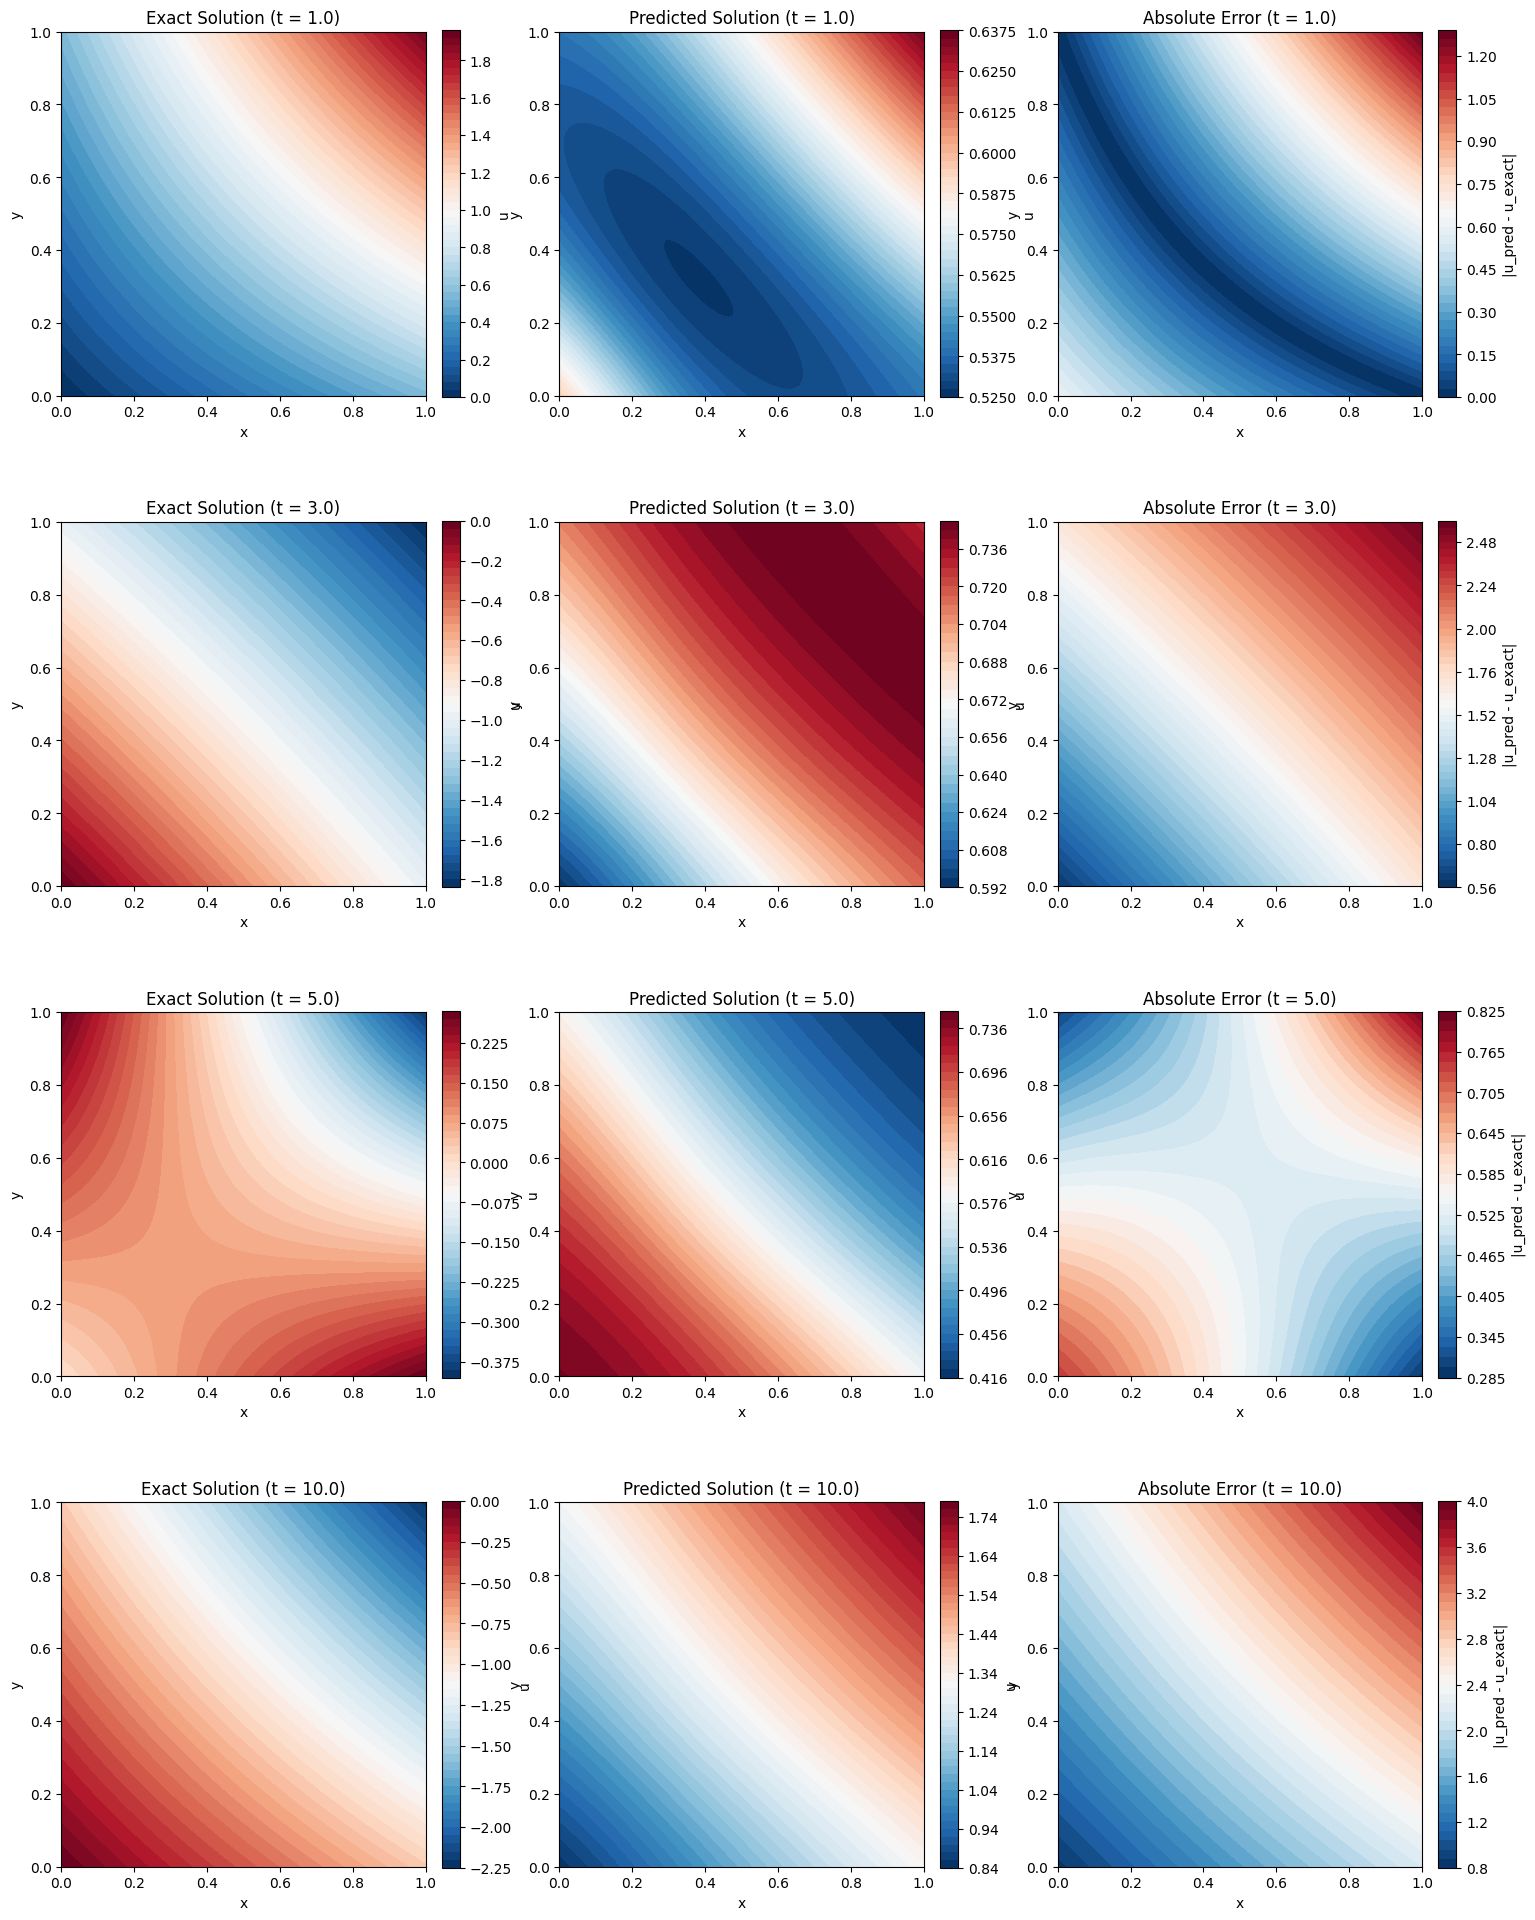

In [20]:

def plot_results(model, final_variables, L_range, H_range, t_slices=[0., 5, 10.0]):
    """Plot results at different time slices"""
    nx_plot, ny_plot = 100, 100
    x_plot = np.linspace(L_range[0], L_range[1], nx_plot)
    y_plot = np.linspace(H_range[0], H_range[1], ny_plot)
    X_mesh, Y_mesh = np.meshgrid(x_plot, y_plot)
    
    # Create figure with GridSpec
    fig = plt.figure(figsize=(18, 6*len(t_slices)))
    gs = gridspec.GridSpec(len(t_slices), 3, width_ratios=[1, 1, 1], 
                          wspace=0.25, hspace=0.3)
    
    for idx, t in enumerate(t_slices):
        # Create input points for this time slice
        xy_points = np.column_stack((X_mesh.ravel(), Y_mesh.ravel(), 
                                   np.full_like(X_mesh.ravel(), t)))
        
        # Get predictions
        pred, _ = model.forward_pass(final_variables, xy_points)
        pred = pred.reshape(nx_plot, ny_plot)
        
        # Get exact solution
        exact = model.exact_solution(X_mesh, Y_mesh, t)
        
        # Compute error
        error = np.abs(pred - exact)
        
        # Compute L2 error for this time slice
        l2_error = np.sqrt(np.mean((pred - exact)**2))
        print(f"L2 error at t = {t}: {l2_error:.6e}")
        
        # Plot exact solution
        ax_exact = plt.subplot(gs[idx, 0])
        im_exact = ax_exact.contourf(X_mesh, Y_mesh, exact, levels=50, cmap='RdBu_r')
        plt.colorbar(im_exact, ax=ax_exact, fraction=0.046, pad=0.04, label='u')
        ax_exact.set_title(f'Exact Solution (t = {t})')
        ax_exact.set_aspect('equal')
        ax_exact.set_xlabel('x')
        ax_exact.set_ylabel('y')
        
        # Plot predicted solution
        ax_pred = plt.subplot(gs[idx, 1])
        im_pred = ax_pred.contourf(X_mesh, Y_mesh, pred, levels=50, cmap='RdBu_r')
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, label='u')
        ax_pred.set_title(f'Predicted Solution (t = {t})')
        ax_pred.set_aspect('equal')
        ax_pred.set_xlabel('x')
        ax_pred.set_ylabel('y')
        
        # Plot error
        ax_error = plt.subplot(gs[idx, 2])
        im_error = ax_error.contourf(X_mesh, Y_mesh, error, levels=50, cmap='RdBu_r')
        plt.colorbar(im_error, ax=ax_error, fraction=0.046, pad=0.04, 
                    label='|u_pred - u_exact|')
        ax_error.set_title(f'Absolute Error (t = {t})')
        ax_error.set_aspect('equal')
        ax_error.set_xlabel('x')
        ax_error.set_ylabel('y')
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_results(model, final_variables, L_range, H_range, t_slices=[1., 3.0, 5.0, 10.0])


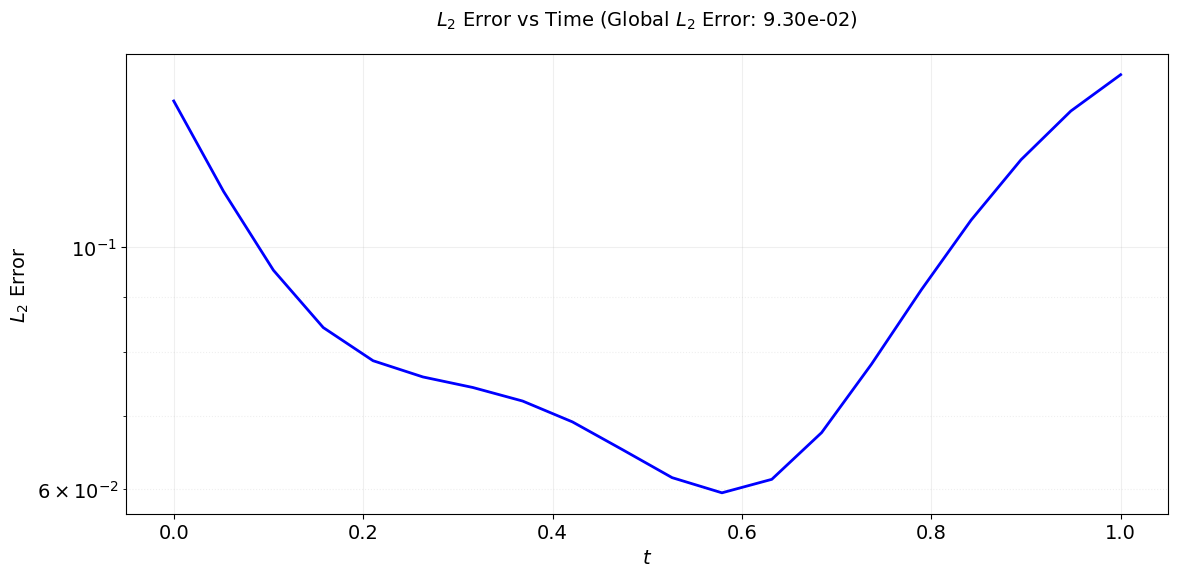

In [45]:
# Compute L2 error at each time step
nx_plot, ny_plot, nt_plot = nx, ny, nt
x_plot = np.linspace(L_range[0], L_range[1], nx_plot)
y_plot = np.linspace(H_range[0], H_range[1], ny_plot)
t_plot = np.linspace(T_range[0], T_range[1], nt_plot)
X_mesh, Y_mesh = np.meshgrid(x_plot, y_plot)

# Initialize arrays
u_pred = np.zeros((nx_plot, ny_plot, nt_plot))
u_exact = np.zeros((nt_plot, ny_plot, nx_plot))
l2_error_t = np.zeros(nt_plot)

# Compute predictions and errors for each time step
for i, t in enumerate(t_plot):
    xy_points = np.column_stack((X_mesh.ravel(), Y_mesh.ravel(), 
                               np.full_like(X_mesh.ravel(), t)))
    pred, _ = model.forward_pass(final_variables, xy_points)
    u_pred[:,:,i] = pred.reshape(nx_plot, ny_plot)
    u_exact[i,:,:] = model.exact_solution(X_mesh, Y_mesh, t)
    l2_error_t[i] = np.sqrt(np.mean((u_pred[:,:,i] - u_exact[i,:,:].T)**2))

# Compute global L2 error
l2_error = np.sqrt(np.mean((u_pred - u_exact.transpose(2,1,0))**2))

# Plot L2 error vs time
fontsize = 14
plt.rcParams.update({
    "font.size": fontsize,
    "axes.labelsize": fontsize,
    "axes.titlesize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize
})

plt.figure(figsize=(12,6))
plt.semilogy(t_plot, l2_error_t, 'b-', linewidth=2)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel(r'$t$', fontsize=fontsize)
plt.ylabel(r'$L_2$ Error', fontsize=fontsize)
plt.title(r'$L_2$ Error vs Time (Global $L_2$ Error: {:.2e})'.format(l2_error), 
          fontsize=fontsize, pad=20)
plt.grid(True, which='minor', linestyle=':', alpha=0.2)
plt.tight_layout()
plt.show()


In [33]:

# Save results
output_data = {
    'mesh': {
        'x_mesh': X_mesh,
        'y_mesh': Y_mesh,
        't': t_plot,
        'L_range': L_range,
        'H_range': H_range,
        'T_range': T_range
    },
    'field_variables': {
        'u_pred': u_pred,          # Shape: (nx, ny, nt)
        'u_exact': u_exact,        # Shape: (nt, ny, nx)
        'u_error': np.abs(u_pred - u_exact.transpose(2,1,0))  # Shape: (nx, ny, nt)
    },
    'parameters': {
        'k_wave': model.k_wave,
        'nx': nx_plot,
        'ny': ny_plot,
        'nt': nt_plot
    },
    'training': {
        'loss_history': loss_history,
        'l2_error': l2_error,
        'l2_error_t': l2_error_t
    }
}

# Save data
np.save(f'./data/2d_kg_pikan_k_{model.k_wave}_{len(loss_history)}epochs.npy', output_data)

In [9]:
def count_trainable_params(params):
    flat_params, _ = jax.tree_util.tree_flatten(params)
    return sum(p.size for p in flat_params)

num_params = count_trainable_params(final_variables['params'])
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 371
